In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import regex
from sklearn.model_selection import train_test_split
import scipy

file_to_open = "catB_train.parquet"

df = pd.read_parquet(file_to_open)

# Data Cleaning

Cleaning the dates to make them ages instead for easy processing by the model.

In [3]:
df3 = df[df.cltdob_fix.isin(['None']) == False]
df4 = df3[df3.min_occ_date.isin(['None']) == False]

df4['cltdob_fix'] = pd.to_datetime(df4['cltdob_fix'])
df4['cltdob_fix_new'] = df4['cltdob_fix'].dt.strftime('%Y-%m-%d')
df4['min_occ_date'] = pd.to_datetime(df4['min_occ_date'])
df4['min_occ_date_new'] = df4['min_occ_date'].dt.strftime('%Y-%m-%d')

# Calculate the difference in years
df4['age_of_purchase'] = (df4['min_occ_date'] - df4['cltdob_fix']).dt.days / 365.25

/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/4260568434.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['cltdob_fix'] = pd.to_datetime(df4['cltdob_fix'])
/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/4260568434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['cltdob_fix_new'] = df4['cltdob_fix'].dt.strftime('%Y-%m-%d')
/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/4260568434.py:6: SettingWithCopyWarning: 
A value is trying to be set o

# Dropping of Empty rows

In dealing with the numerous columns with empty entries, we adopted an 80% threshold to drop the columns with NA values as an indicator of a lack of usefulness of the column in predicting it. 

Additionally, we dropped columns that were near 0, which similarly indicates low predictive power. 

In [4]:
df4 = df4.dropna(subset=['race_desc'])
df4 = df4.dropna(subset=['flg_substandard'])

In [5]:
#manipulating household data size
df4 = df4.dropna(subset=['hh_size_est'])

# Replace rows where 'hh_size_est' is ">4" with the default value 5
df4['hh_size_est'] = df4['hh_size_est'].replace('>4', 5)
df4['hh_size_est'] = pd.to_numeric(df4['hh_size_est'])

In [6]:
#manipulating household income
df4 = df4.dropna(subset=['annual_income_est'])

#Replace rows in 'annual_income_est' to numeric
df4['annual_income_est'] = df4['annual_income_est'].replace('A.ABOVE200K', 1)
df4['annual_income_est'] = df4['annual_income_est'].replace('B.100K-200K', 2)
df4['annual_income_est'] = df4['annual_income_est'].replace('C.60K-100K', 3)
df4['annual_income_est'] = df4['annual_income_est'].replace('D.30K-60K', 4)
df4['annual_income_est'] = df4['annual_income_est'].replace('E.BELOW30K', 5)

In [7]:
#fill recency_lapse and recency_cancel, tot_cancel_pols
# Select columns to fill with 0 if NaN
columns_to_fill = ['recency_lapse', 'recency_cancel', 'tot_cancel_pols']

# Fill NaN values in selected columns with 0
df4[columns_to_fill] = df4[columns_to_fill].fillna(0)

Noticing that for ape, sumins. prempaid, and lapse_ape columns were split by individual product types, we conducted an aggregation of the data. 

The aggregation of individual product columns serves to streamline the feature space, reducing dimensionality and potential complexities associated with managing numerous predictor variables. By condensing the information into a single indicator variable, we create a more manageable and efficient dataset, conducive to model training, evaluation, and deployment.

Aggregating related columns aids in addressing multicollinearity concerns that may arise from interdependencies among individual product indicators. By condensing this information into a single variable, we mitigate the risk of redundancy and collinearity, contributing to the stability and reliability of subsequent statistical models.

In [8]:
#ape

df_ape = df4.filter(regex=r'^ape_')
selected_columns4 = list(df_ape.columns)


# Convert selected columns to integer
df4[selected_columns4] = df4[selected_columns4].fillna(0)
df4[selected_columns4] = df4[selected_columns4].astype(int)


# Create a new column
df4['total_ape'] = df4[selected_columns4].sum(axis=1)

In [9]:
#sumins 
df_sum = df4.filter(regex=r'^sumins_')
selected_columns2 = list(df_sum.columns)

# Convert selected columns to integer
df4[selected_columns2] = df4[selected_columns2].fillna(0)
df4[selected_columns2] = df4[selected_columns2].astype(int)

# Create a new column with the minimum value
df4['total_sumin'] = df4[selected_columns2].sum(axis=1)

In [10]:
#prempaid 
df_prem = df4.filter(regex=r'^prempaid_')
selected_columns3 = list(df_prem.columns)

# Convert selected columns to integer
df4[selected_columns3] = df4[selected_columns3].fillna(0)
df4[selected_columns3] = df4[selected_columns3].astype(int)

# Create a new column
df4['total_prempaid'] = df4[selected_columns3].sum(axis=1)

/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/3495051285.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df4['total_prempaid'] = df4[selected_columns3].sum(axis=1)


In [11]:

df_lapse_ape = df4.filter(regex=r'^lapse_ape')
selected_columns = list(df_lapse_ape.columns)

# Convert selected columns to integer
df4[selected_columns] = df4[selected_columns].fillna(0)
df4[selected_columns] = df4[selected_columns].astype(int)

# Create a new column
df4['total_lapse_ape'] = df4[selected_columns].sum(axis=1)


/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/1083932920.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df4['total_lapse_ape'] = df4[selected_columns].sum(axis=1)


In [12]:
selected_columns = ['hlthclaim_amt', 'giclaim_amt', 'f_purchase_lh']
df4[selected_columns] = df4[selected_columns].fillna(0)

In [13]:
# Select columns to fill with 0 if NaN

columns_to_fill = ['recency_hlthclaim', 'recency_hlthclaim_success']

# Fill NaN values in selected columns with 0
df4[columns_to_fill] = df4[columns_to_fill].fillna(0)

df4['recency_hlthclaim_percentage'] = np.where(df4['recency_hlthclaim'] != 0, (df4['recency_hlthclaim_success'] / df4['recency_hlthclaim']) * 100, 0)

/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/3307070031.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df4['recency_hlthclaim_percentage'] = np.where(df4['recency_hlthclaim'] != 0, (df4['recency_hlthclaim_success'] / df4['recency_hlthclaim']) * 100, 0)


In [14]:
# Select columns to fill with 0 if NaN
columns_to_fill2 = ['recency_giclaim', 'recency_giclaim_success']

# Fill NaN values in selected columns with 0
df4[columns_to_fill2] = df4[columns_to_fill2].fillna(0)

df4['recency_giclaim_percentage'] = np.where(df4['recency_giclaim'] != 0, (df4['recency_giclaim_success'] / df4['recency_giclaim']) * 100, 0)

/var/folders/h0/n4k63yd150v65l7c1rhpt86h0000gn/T/ipykernel_54402/1974544164.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df4['recency_giclaim_percentage'] = np.where(df4['recency_giclaim'] != 0, (df4['recency_giclaim_success'] / df4['recency_giclaim']) * 100, 0)


In [15]:
def chi_square_test(dataframe, dependent, independent):
    dataframe = df.loc[:, [dependent, independent]].fillna(0)
    contingency_table = pd.crosstab(dataframe[independent], dataframe[dependent])
    chi2_stat, p_val, _, _ = scipy.stats.chi2_contingency(contingency_table)
    return chi2_stat, p_val

#dropping columns based on chi-square p value > 0.05
print(chi_square_test(df, "is_consent_to_email", "f_purchase_lh"))
print(chi_square_test(df, "is_consent_to_mail", "f_purchase_lh"))
print(chi_square_test(df, "is_consent_to_sms", "f_purchase_lh"))
print(chi_square_test(df, "is_consent_to_call", "f_purchase_lh"))

(0.1058584267877858, 0.7449094426916558)
(43.36912165902902, 4.5328494991478234e-11)
(18.30545071908081, 1.8816800608860838e-05)
(44.984065521598865, 1.9864429756553147e-11)


In [16]:
# List of columns to drop
columns_to_drop = ['is_consent_to_email',#not significant based on chi square
'f_ever_declined_la',
'hh_20',#household size estimate
'pop_20',#household size estimate
'hh_size',#household size estimate
'ape_gi_42e115',#summed up for all ape
'ape_ltc_1280bf',
'ape_grp_6fc3e6',
'ape_grp_de05ae',
'ape_inv_dcd836',
'ape_grp_945b5a',
'ape_grp_6a5788',
'ape_ltc_43b9d5',
'ape_grp_9cdedf',
'ape_lh_d0adeb',
'ape_grp_1581d7',
'ape_grp_22decf',
'ape_lh_507c37',
'ape_lh_839f8a',
'ape_inv_e9f316',
'ape_gi_a10d1b',
'ape_gi_29d435',
'ape_grp_caa6ff',
'ape_grp_fd3bfb',
'ape_lh_e22a6a',
'ape_grp_70e1dd',
'ape_grp_e04c3a',
'ape_grp_fe5fb8',
'ape_gi_856320',
'ape_grp_94baec',
'ape_gi_058815',
'ape_grp_e91421',
'ape_lh_f852af',
'ape_lh_947b15',
'ape_32c74c',
'sumins_gi_42e115',#summed up for all sumins
'sumins_ltc_1280bf',
'sumins_grp_6fc3e6',
'sumins_grp_de05ae',
'sumins_inv_dcd836',
'sumins_grp_945b5a',
'sumins_grp_6a5788',
'sumins_ltc_43b9d5',
'sumins_grp_9cdedf',
'sumins_lh_d0adeb',
'sumins_grp_1581d7',
'sumins_grp_22decf',
'sumins_lh_507c37',
'sumins_inv_e9f316',
'sumins_gi_a10d1b',
'sumins_gi_29d435',
'sumins_grp_caa6ff',
'sumins_grp_fd3bfb',
'sumins_lh_e22a6a',
'sumins_grp_70e1dd',
'sumins_grp_e04c3a',
'sumins_grp_fe5fb8',
'sumins_gi_856320',
'sumins_grp_94baec',
'sumins_gi_058815',
'sumins_grp_e91421',
'sumins_lh_f852af',
'sumins_lh_947b15',
'sumins_32c74c',
'prempaid_gi_42e115',#summed up for all prempaid
'prempaid_ltc_1280bf',
'prempaid_grp_6fc3e6',
'prempaid_grp_de05ae',
'prempaid_inv_dcd836',
'prempaid_grp_945b5a',
'prempaid_grp_6a5788',
'prempaid_ltc_43b9d5',
'prempaid_grp_9cdedf',
'prempaid_lh_d0adeb',
'prempaid_grp_1581d7',
'prempaid_grp_22decf',
'prempaid_lh_507c37',
'prempaid_lh_839f8a',
'prempaid_inv_e9f316',
'prempaid_gi_a10d1b',
'prempaid_gi_29d435',
'prempaid_grp_caa6ff',
'prempaid_grp_fd3bfb',
'prempaid_lh_e22a6a',
'prempaid_grp_70e1dd',
'prempaid_grp_e04c3a',
'prempaid_grp_fe5fb8',
'prempaid_gi_856320',
'prempaid_grp_94baec',
'prempaid_gi_058815',
'prempaid_grp_e91421',
'prempaid_lh_f852af',
'prempaid_lh_947b15',
'prempaid_32c74c',
'ape_839f8a',
'ape_e22a6a',
'ape_d0adeb',
'ape_c4bda5',
'ape_ltc',
'ape_507c37',
'ape_gi',
'f_hold_839f8a',#already have a column indicating whether they have a insurance
'f_hold_e22a6a',
'f_hold_d0adeb',
'f_hold_c4bda5',
'f_hold_ltc',
'f_hold_507c37',
'f_hold_gi',
'sumins_839f8a',
'sumins_e22a6a',
'sumins_d0adeb',
'sumins_c4bda5',
'sumins_ltc',
'sumins_507c37',
'sumins_gi',
'prempaid_839f8a',
'prempaid_e22a6a',
'prempaid_d0adeb',
'prempaid_c4bda5',
'prempaid_ltc',
'prempaid_507c37',
'prempaid_gi',
'lapse_ape_ltc_1280bf',#sum up lapse_ape
'lapse_ape_grp_6fc3e6',
'lapse_ape_grp_de05ae',
'lapse_ape_inv_dcd836',
'lapse_ape_grp_945b5a',
'lapse_ape_grp_6a5788',
'lapse_ape_ltc_43b9d5',
'lapse_ape_grp_9cdedf',
'lapse_ape_lh_d0adeb',
'lapse_ape_grp_1581d7',
'lapse_ape_grp_22decf',
'lapse_ape_lh_507c37',
'lapse_ape_lh_839f8a',
'lapse_ape_inv_e9f316',
'lapse_ape_grp_caa6ff',
'lapse_ape_grp_fd3bfb',
'lapse_ape_lh_e22a6a',
'lapse_ape_grp_70e1dd',
'lapse_ape_grp_e04c3a',
'lapse_ape_grp_fe5fb8',
'lapse_ape_grp_94baec',
'lapse_ape_grp_e91421',
'lapse_ape_lh_f852af',
'lapse_ape_lh_947b15',
'lapse_ape_32c74c',
'n_months_since_lapse_ltc_1280bf',#already have a n_months summary
'n_months_since_lapse_grp_6fc3e6',
'n_months_since_lapse_grp_de05ae',
'n_months_since_lapse_inv_dcd836',
'n_months_since_lapse_grp_945b5a',
'n_months_since_lapse_grp_6a5788',
'n_months_since_lapse_ltc_43b9d5',
'n_months_since_lapse_grp_9cdedf',
'n_months_since_lapse_lh_d0adeb',
'n_months_since_lapse_grp_1581d7',
'n_months_since_lapse_grp_22decf',
'n_months_since_lapse_lh_507c37',
'n_months_since_lapse_lh_839f8a',
'n_months_since_lapse_inv_e9f316',
'n_months_since_lapse_grp_caa6ff',
'n_months_since_lapse_grp_fd3bfb',
'n_months_since_lapse_lh_e22a6a',
'n_months_since_lapse_grp_70e1dd',
'n_months_since_lapse_grp_e04c3a',
'n_months_since_lapse_grp_fe5fb8',
'n_months_since_lapse_grp_94baec',
'n_months_since_lapse_grp_e91421',
'n_months_since_lapse_lh_f852af',
'n_months_since_lapse_lh_947b15',
'n_months_since_lapse_32c74c',
'f_ever_bought_839f8a',
'f_ever_bought_e22a6a',
'f_ever_bought_d0adeb',
'f_ever_bought_c4bda5',
'f_ever_bought_ltc',
'f_ever_bought_507c37',
'f_ever_bought_gi',
'n_months_last_bought_839f8a',
'n_months_last_bought_e22a6a',
'n_months_last_bought_d0adeb',
'n_months_last_bought_c4bda5',
'n_months_last_bought_ltc',
'n_months_last_bought_507c37',
'n_months_last_bought_gi',
'f_ever_bought_ltc_1280bf',
'f_ever_bought_grp_6fc3e6',
'f_ever_bought_grp_de05ae',
'f_ever_bought_inv_dcd836',
'f_ever_bought_grp_945b5a',
'f_ever_bought_grp_6a5788',
'f_ever_bought_ltc_43b9d5',
'f_ever_bought_grp_9cdedf',
'f_ever_bought_lh_d0adeb',
'f_ever_bought_grp_1581d7',
'f_ever_bought_grp_22decf',
'f_ever_bought_lh_507c37',
'f_ever_bought_lh_839f8a',
'f_ever_bought_inv_e9f316',
'f_ever_bought_grp_caa6ff',
'f_ever_bought_grp_fd3bfb',
'f_ever_bought_lh_e22a6a',
'f_ever_bought_grp_70e1dd',
'f_ever_bought_grp_e04c3a',
'f_ever_bought_grp_fe5fb8',
'f_ever_bought_grp_94baec',
'f_ever_bought_grp_e91421',
'f_ever_bought_lh_f852af',
'f_ever_bought_lh_947b15',
'f_ever_bought_32c74c',
'n_months_last_bought_ltc_1280bf',
'n_months_last_bought_grp_6fc3e6',
'n_months_last_bought_grp_de05ae',
'n_months_last_bought_inv_dcd836',
'n_months_last_bought_grp_945b5a',
'n_months_last_bought_grp_6a5788',
'n_months_last_bought_ltc_43b9d5',
'n_months_last_bought_grp_9cdedf',
'n_months_last_bought_lh_d0adeb',
'n_months_last_bought_grp_1581d7',
'n_months_last_bought_grp_22decf',
'n_months_last_bought_lh_507c37',
'n_months_last_bought_lh_839f8a',
'n_months_last_bought_inv_e9f316',
'n_months_last_bought_grp_caa6ff',
'n_months_last_bought_grp_fd3bfb',
'n_months_last_bought_lh_e22a6a',
'n_months_last_bought_grp_70e1dd',
'n_months_last_bought_grp_e04c3a',
'n_months_last_bought_grp_fe5fb8',
'n_months_last_bought_grp_94baec',
'n_months_last_bought_grp_e91421',
'n_months_last_bought_lh_f852af',
'n_months_last_bought_lh_947b15',
'n_months_last_bought_32c74c',
'flg_affconnect_show_interest_ever',#not raw data
'flg_affconnect_ready_to_buy_ever',
'flg_affconnect_lapse_ever',
'affcon_visit_days',
'n_months_since_visit_affcon',
'clmcon_visit_days',
'recency_clmcon',
'recency_clmcon_regis',
'hlthclaim_cnt_success',#summarised under percentage column
'hlthclaim_cnt_unsuccess',
'recency_hlthclaim_unsuccess',
'flg_hlthclaim_839f8a_ever',
'recency_hlthclaim_839f8a',
'flg_hlthclaim_14cb37_ever',
'recency_hlthclaim_14cb37',
'giclaim_cnt_success',
'giclaim_cnt_unsuccess',
'recency_giclaim_unsuccess',
'flg_gi_claim_29d435_ever',
'flg_gi_claim_058815_ever',
'flg_gi_claim_42e115_ever',
'flg_gi_claim_856320_ever',
'cltdob_fix_new',#summarised under age of purchase
'min_occ_date_new',
'min_occ_date',
'cltdob_fix',
'clntnum']

# Drop the specified columns
df4 = df4.drop(columns=columns_to_drop)

One-hot encoding for the categorical variable columns.

In [17]:
category_dict = {category: idx for idx, category in enumerate(df4['race_desc'].unique())}
df4['race_desc']  = pd.factorize(df4['race_desc'])[0]

In [18]:
category_dict = {category: idx for idx, category in enumerate(df4['ctrycode_desc'].unique())}
df4['ctrycode_desc']  = pd.factorize(df4['ctrycode_desc'])[0]

In [19]:
category_dict = {category: idx for idx, category in enumerate(df4['clttype'].unique())}
df4['clttype']  = pd.factorize(df4['clttype'])[0]

In [20]:
category_dict = {category: idx for idx, category in enumerate(df4['stat_flag'].unique())}
df4['stat_flag']  = pd.factorize(df4['stat_flag'])[0]

In [21]:
category_dict = {category: idx for idx, category in enumerate(df4['cltsex_fix'].unique())}
df4['cltsex_fix']  = pd.factorize(df4['cltsex_fix'])[0]

In [22]:
df4 = pd.get_dummies(df4, columns=['race_desc', 'ctrycode_desc', 'clttype', 'stat_flag', 'cltsex_fix'], drop_first=True)

## Exploratory Data Analysis

The correlation matrix below demonstrates that the data cleaning is successful. There is no clear evidence of multicollinearity between the different variables that could contribute to a more inaccurate model. 

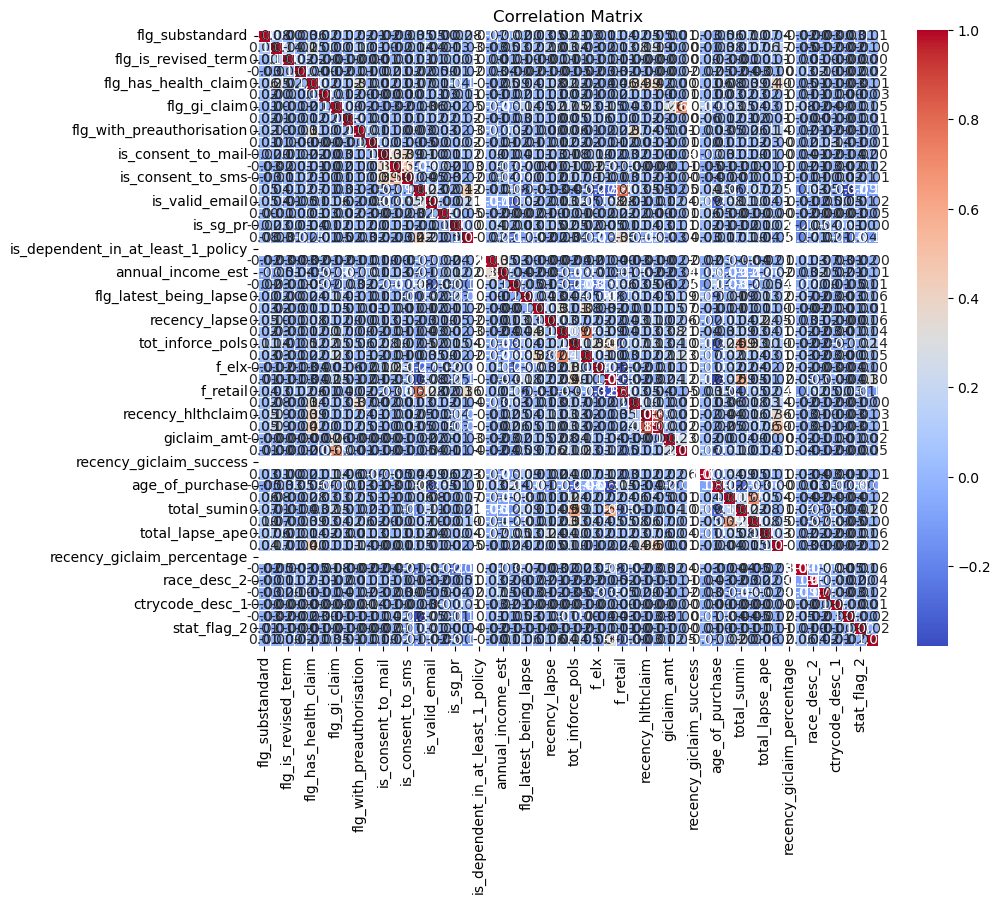

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df4.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add a title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [38]:
selected_col = df4.loc[:, 'age_of_purchase':'recency_giclaim_percentage']
selected_col.describe()

,age_of_purchase,total_ape,total_sumin,total_prempaid,total_lapse_ape,recency_hlthclaim_percentage,recency_giclaim_percentage
count,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.0
mean,36.973850,3166.156653,5.777477e+05,1.481180e+05,291.457366,10.025833,0.0
std,11.241076,10686.395143,1.665064e+06,3.701895e+05,1188.751398,54.694548,0.0
min,0.391513,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
25%,28.711841,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
50%,36.947296,1076.000000,2.000000e+03,5.671000e+04,0.000000,0.000000,0.0
75%,42.112936,3061.500000,4.020000e+05,1.565355e+05,0.000000,0.000000,0.0
max,89.524983,788130.000000,2.580000e+07,1.981257e+07,44789.000000,4150.000000,0.0


Histograms of the ages of the dataset, from the plots, it is likely that we find younger ages as a predictor for the propensity to purchase insurance. 

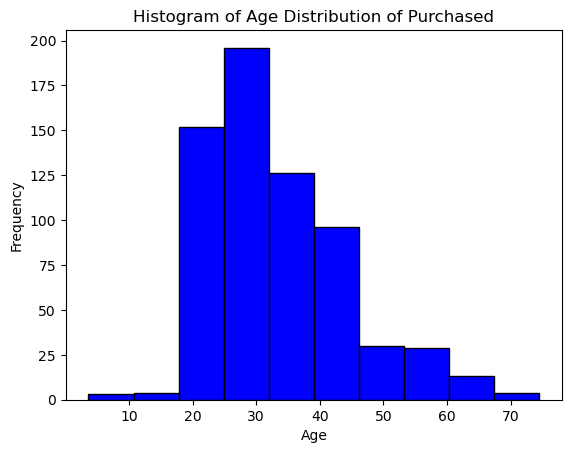

In [29]:
import matplotlib.pyplot as plt

filtered_df = df4[df4['f_purchase_lh']==1]
age_column = filtered_df['age_of_purchase']

plt.hist(age_column, bins=10, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age Distribution of Purchased')

# Show the plot
plt.show()

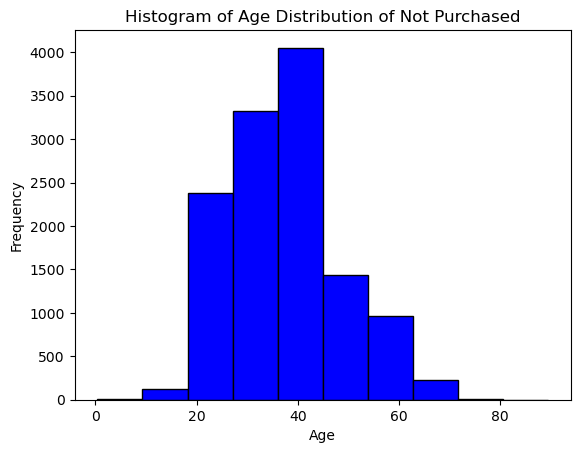

In [31]:
import matplotlib.pyplot as plt

filtered_df = df4[df4['f_purchase_lh']!=1]
age_column = filtered_df['age_of_purchase']

plt.hist(age_column, bins=10, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age Distribution of Not Purchased')

# Show the plot
plt.show()

## Dealing with the Imbalanced classes

The stark class imbalance in the target column, with only 2% positive entries, can significantly skew the learning process of machine learning models, leading to biased predictions. SMOTE systematically addresses this issue by synthesizing artificial instances of the minority class, thereby rectifying the imbalance and fostering a more equitable representation of both classes.

In [37]:
from imblearn.over_sampling import SMOTE
#smoting data
def smote_data(dataframe, target_column):
    X = dataframe.drop(target_column, axis=1)
    Y = dataframe[target_column].fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    smote = SMOTE(random_state=33)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, X_test, y_test, y_train_resampled

X_train_resampled, X_test, y_test, y_train_resampled = smote_data(df4, 'f_purchase_lh')

### Initially tested a random forest classifier. 

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
random_forest_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)

0.9476678043230944
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      2514
         1.0       0.36      0.15      0.22       123

    accuracy                           0.95      2637
   macro avg       0.66      0.57      0.59      2637
weighted avg       0.93      0.95      0.94      2637



### Logistic Regression Models

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Create a Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=42, max_iter=10000)

# Train the model on the training set
logistic_regression_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test)

# Get the coefficients and corresponding feature names
coefficients = logistic_regression_model.coef_[0]
feature_names = X_train_resampled.columns

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of coefficients in descending order
coefficients_df['Absolute Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the DataFrame
print(coefficients_df)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("Classification Report:\n", report)

                              Feature   Coefficient  Absolute Coefficient
35                    recency_giclaim  2.764772e-02          2.764772e-02
21      n_months_last_bought_products -1.469554e-02          1.469554e-02
32                  recency_hlthclaim  1.276078e-02          1.276078e-02
20                  annual_income_est -1.256975e-02          1.256975e-02
25                     recency_cancel  9.657741e-03          9.657741e-03
14                     is_valid_email  6.606202e-03          6.606202e-03
33          recency_hlthclaim_success -6.353463e-03          6.353463e-03
50                       cltsex_fix_1  5.695382e-03          5.695382e-03
13                        is_valid_dm  5.530313e-03          5.530313e-03
37                    age_of_purchase  5.447166e-03          5.447166e-03
44                        race_desc_1  5.249065e-03          5.249065e-03
19                        hh_size_est -4.838421e-03          4.838421e-03
17                       is_class_1_2 

/Users/jeremy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tested out embedded feature engineering method, using L1 regularisation to select the best 

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create a Logistic Regression model with L1 regularization
logistic_regression_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=10000)

# Train the model on the resampled training set
logistic_regression_model.fit(X_train_resampled, y_train_resampled)

# Get the coefficients and corresponding feature names
coefficients = logistic_regression_model.coef_[0]
feature_names = X_train_resampled.columns

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df['Absolute Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print out the coefficients with feature names
print("Coefficients:")
print(coefficients_df)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nAccuracy with all features:", accuracy)
print("Classification Report with all features:\n", report)


Coefficients:
                              Feature   Coefficient  Absolute Coefficient
30                           f_retail -4.386995e+00          4.386995e+00
13                        is_valid_dm  4.370366e+00          4.370366e+00
15               is_housewife_retiree  3.993961e+00          3.993961e+00
23            flg_latest_being_cancel -3.059002e+00          3.059002e+00
48                        stat_flag_1  2.659777e+00          2.659777e+00
7                     flg_is_proposal  2.442963e+00          2.442963e+00
28                              f_elx -2.173472e+00          2.173472e+00
6                        flg_gi_claim  1.722199e+00          1.722199e+00
16                           is_sg_pr  1.706116e+00          1.706116e+00
3                  flg_is_rental_flat -1.609519e+00          1.609519e+00
14                     is_valid_email  1.307273e+00          1.307273e+00
44                        race_desc_1  9.811002e-01          9.811002e-01
22             flg_lates

## Selection of the Models

When we first tested a random forest classifier, we noticed that recall rates was 0.15, implying that the ratio of true predicted positive to all true positive is very low and that the model is not predicting the positives accurately.

Next, we decided to use svm, however the runtime was way too long because of the time complexity and we decided to switch to logistics regression instead.

As for logistics regression, we tried running a model with l1 regularisation feature selection and a model without. We have decided to pick the one without feature selection because of the higher recall rate. Even though precision for positive data is way lower at 0.09, however we did realise that this is attributed to our test data imbalance rather than model inaccuracy. Since we only smoted our training data (from what we researched, this is standard practice), that means our test data still has a huge imbalance and that means that even the ratio of false negative to predicted negative is not high, the number of false negatives is still way higher than even the number of positive data we have in our validation set. This means positive precision rates is not an accurate validator for our model and we should not be looking at it in the first place. Hence, we pick the model that we think has the least overfitting problems, where positive recall rates and negative recall rates are almost similar, both rounded up to 0.7, which is the logistics regression model without feature selection

## Interpretation of the Model and Recommendations

Based on the model, we have come to the following conclusions and recommendations.

### Retention and Re-engagement Initiatives
The logistic regression model has pinpointed recency of general insurance claims (recency_giclaim) and the number of months since the last product purchase (n_months_last_bought_products) as critical factors in customer retention. Building on this insight, personalized retention initiatives for customers with recent claims and targeted re-engagement campaigns for those with a longer lapse since their last purchase will form the core of our customer relationship management strategy.

### Leveraging Effective Communication Channels
Recognizing the influence of communication channels, we emphasize email communication (is_valid_email) for policy updates, promotions, and general information dissemination. Additionally, leveraging valid direct mail contacts (is_valid_dm) enables targeted marketing campaigns, enhancing our reach and impact.

### Age-Responsive Products and Services:

Develop age-responsive insurance products and services to cater to the diverse needs and preferences of different age groups. Consider age-specific promotions or benefits to increase customer satisfaction and loyalty within each demographic. Contrary to our expectations from the exploratory data analysis, the model actually indicates that the higher the age the higher propensity to purchase insurance. This more closely aligns with intuition, whereby people of higher ages are more likely to have insurance needs than younger people. 